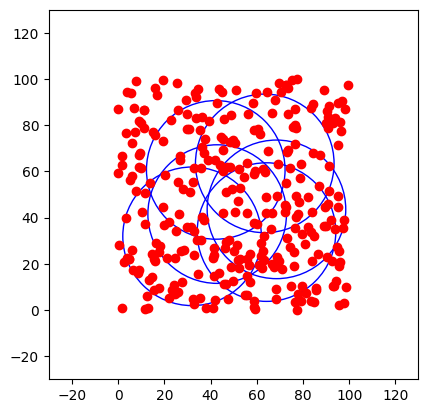

In [ ]:
import random
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CircleSet(Dataset):
    def __init__(self, minX, minY, maxX, maxY, minRadius, maxRadius, numCircles, numPoints):
        self.minX = minX
        self.minY = minY
        self.maxX = maxX
        self.maxY = maxY
        self.minRadius = minRadius
        self.maxRadius = maxRadius
        self.numCircles = numCircles
        self.circles: list[tuple[float, float, float]] = []
        self.num_classes = numCircles
        if numCircles < 0:
            self.numCircles = numCircles * -1
            
            pass
        else:
        # get random x,y,radius
            for i in range(numCircles):
                radius = random.uniform(minRadius, maxRadius)
                x = random.uniform(minX + radius, maxX - radius)
                y = random.uniform(minY + radius, maxY - radius)
                self.circles.append((x, y, radius))
        self.numPoints = numPoints
        self.points: list[tuple[float, float]] = []
        self.x= []
        self.y= []
        # get random points
        for i in range(numPoints):
            x = random.uniform(minX, maxX)
            y = random.uniform(minY, maxY)
            self.points.append((x, y))
        for point in self.points:
            x, y = point
            self.x.append([x, y])
            circles = self.circles_of_point(point)
            one_hot = [0] * numCircles
            for circle in circles:
                one_hot[circle] = 1
            self.y.append(one_hot)
            
        self.x_tensor = torch.tensor(self.x, dtype=torch.float32, device=device)
        self.y_tensor = torch.tensor(self.y, dtype=torch.float32, device=device)
        


    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x_tensor[idx], self.y_tensor[idx]   
    
    def circles_of_point(self, point):
        x, y = point
        circles = []
        for i in range(self.numCircles):
            circle = self.circles[i]
            circleX, circleY, radius = circle
            if (x - circleX) ** 2 + (y - circleY) ** 2 <= radius ** 2:
                circles.append(i)
        return circles

    def print(self):
        for x,y in self:
            print(f"Point: {x}, Circles: {y}")
    
    def display(self):
        fig, ax = plt.subplots()
        # draw each circle
        for (x, y, radius) in self.circles:
            circle = Circle((x, y), radius, fill=False, edgecolor='blue')
            ax.add_patch(circle)
        # draw points
        if self.points:
            x_points, y_points = zip(*self.points)
            ax.scatter(x_points, y_points, color='red', zorder=5)
        # set limits with a margin
        ax.set_xlim(self.minX - self.maxRadius, self.maxX + self.maxRadius)
        ax.set_ylim(self.minY - self.maxRadius, self.maxY + self.maxRadius)
        ax.set_aspect('equal')
        plt.show()

class CircleModel(torch.nn.Module):
    def __init__(self, numCircles,neurons_per_circle=4):
        super(CircleModel, self).__init__()
        self.net=torch.nn.Sequential(
            torch.nn.Linear(2, neurons_per_circle*numCircles),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_per_circle*numCircles, neurons_per_circle*numCircles),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_per_circle*numCircles, numCircles)
        ) 

    def forward(self, x):
        return self.net(x)
    
    def train_model(self, dataset, num_epochs=1000, batch_size=32, learning_rate=0.001, early_stopping=0.05):
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs):
            avg_loss = 0.0
            for x_batch, y_batch in dataloader:
                logits = self(x_batch)
                loss = criterion(logits, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()
            avg_loss /= len(dataloader)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}")
            if avg_loss < early_stopping:
                print(f"Early stopping at epoch {epoch} with loss {avg_loss:.4f}")
                break
    def evaluate(self, dataset,batch_size=1024):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            dataloader= DataLoader(dataset, batch_size=batch_size, shuffle=False)
            for x_batch, y_batch in dataloader:
                logits = self(x_batch)
                predictions = torch.sigmoid(logits) > 0.5
                real_labels = y_batch > 0.5
                results = predictions == real_labels
                correct += results.sum().item()
                total += results.numel()
                
            accuracy = correct / total
            print(f"total: {total}, correct: {correct}, accuracy: {accuracy:.4f}")
    def train_and_evaluate(self, dataset,split, num_epochs=1000, batch_size=32, learning_rate=0.001, early_stopping=0.05):
        train_size = int(len(dataset) * split)
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        self.train_model(train_dataset, num_epochs=num_epochs, batch_size=batch_size, learning_rate=learning_rate, early_stopping=early_stopping)
        self.evaluate(test_dataset,batch_size=batch_size)

circle_count=6
circle_model = CircleModel(numCircles=circle_count,neurons_per_circle=4)
circle_model=circle_model.to(device)
dataset = CircleSet(minX=0, minY=0, maxX=100, maxY=100, minRadius=30, maxRadius=30, numCircles=circle_count, numPoints=300)
dataset.display()
# circle_model.train_and_evaluate(dataset,split=0.8, num_epochs=5000, batch_size=1024, learning_rate=0.01, early_stopping=0.05)